In [4]:
using Laplacians, LinearAlgebra, SparseArrays
using TestImages, Colors, Plots, FileIO, JLD

In [5]:
include("ThinPlateSplines.jl")

Main.ThinPlateSplines

In [6]:
x1 = [0.0 1.0 
      1.0 0.0
      1.0 1.0]

x2 = [0.0 1.0
      1.1 0.0
      1.2 1.5]

tps = ThinPlateSplines.tps_solve(x1,x2,1.0)

Main.ThinPlateSplines.ThinPlateSpline(1.0, [0.0 1.0; 1.0 0.0; 1.0 1.0], [1.0 0.0 1.0; 1.0 1.1 0.0; 1.0 1.2 1.5], [0.0 0.6931471805599455 0.0; 0.6931471805599455 0.0 0.0; 0.0 0.0 0.0], [1.0 -0.09999999999999973 -0.4999999999999996; 3.294173637189667e-16 1.1999999999999997 0.49999999999999967; -1.5700924586837752e-16 0.09999999999999981 1.4999999999999996], [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0])

In [7]:
x = [1.0 0.0
     2.0 2.0]
ThinPlateSplines.tps_deform(x,tps)

2×2 Array{Float64,2}:
 1.1  5.55112e-17
 2.5  3.5

In [8]:
img = testimage("mandrill");
imgg = Gray.(img);
mat = convert(Array{Float64}, imgg)[1:256,1:512];
# This image is square
#plot(imgg)
rows = size(mat,1);
columns = size(mat,2);
BoundaryNodes1 = collect(1:rows);
BoundaryNodes2 = collect(rows+1:rows:rows*columns-rows+1);
BoundaryNodes3 = collect(rows*columns-rows+2:rows*columns);
BoundaryNodes4 = collect(2*rows:rows:(columns-1)*rows);
BoundaryNodes= union(BoundaryNodes1, BoundaryNodes2, BoundaryNodes3, BoundaryNodes4);
AllNodes = collect(1:rows*columns)
NonBoundaryNodes = setdiff(AllNodes, BoundaryNodes);
size(NonBoundaryNodes);

In [9]:
cent = [(100, 200), (200, 100), (400, 200)]
c = cent[1]
rad = 20

L = 1:size(mat,1)
K = 1:size(mat,2)

mask = ones(size(mat))
mask = broadcast(+, (L .- c[1]).^2, (K .- c[2])'.^2) .> rad^2

keep = collect(1:prod(size(mat)))

fun(c, k) = filter(x -> (floor(x/size(mat,1)) .- c[1]).^2 + (x%size(mat,1) .- c[2])'.^2 > rad^2, k)

keep = fun(cent[1], keep)
keep = fun(cent[2], keep)
keep = fun(cent[3], keep)

prod(size(mask)) - sum(mask[keep]), 2*20^2*pi;

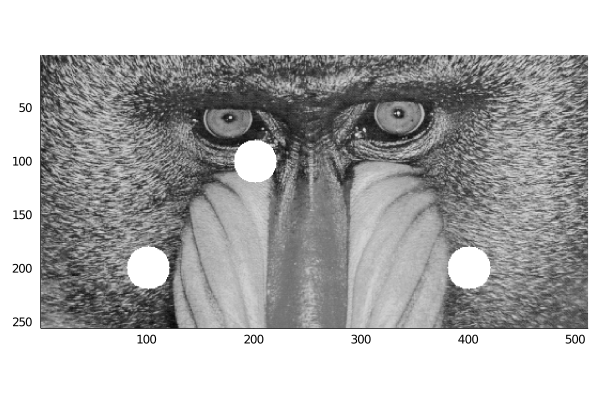

In [10]:
S = [i*size(mat,2)+j for i in 0:(size(mat,1)-1) for j in 1:size(mat,2)]
vals = mat[:]
holeyimage = ones(size(mat,1),size(mat,2))
holeyimage[S[keep]] = vals[keep]
Plots.plot(Gray.(holeyimage))

In [134]:
 # if you need
using PyPlot
using LinearAlgebra
using BenchmarkTools

include("polyharmonic_splines.jl") 
# contain all code from https://github.com/lstagner/OrbitTomography.jl/blob/master/src/polyharmonic.jl
# and `interpolate()`definition from https://gist.github.com/lstagner/04a05b120e0be7de9915

# x = floor.(keep/(size(mat,1)));
# y = (keep.%(size(mat,1)));
# z = holeyimage[S[keep]];
# S2 = PolyharmonicSpline(2,[x y],z)

BenchmarkTools.DEFAULT_PARAMETERS.seconds = 1000;
BenchmarkTools.DEFAULT_PARAMETERS.samples = 50;

@benchmark begin
    
xarray = Float64[]
yarray = Float64[]
zarray = Float64[]
for x in 80:120
    for y in 180:220
        if((x -100)^2 + (y-200)^2 > 20^2)
            xarray = append!(xarray, x);
            yarray = append!(yarray, y);
            zarray = append!(zarray, mat[y,x]);
        end
    end
end

for x in 380:420
    for y in 180:220
        if((x -400)^2 + (y-200)^2 > 20^2)
            xarray = append!(xarray, x);
            yarray = append!(yarray, y);
            zarray = append!(zarray, mat[y,x]);
        end
    end
end

for x in 180:220
    for y in 80:120
        if((x -200)^2 + (y-100)^2 > 20^2)
            xarray = append!(xarray, x);
            yarray = append!(yarray, y);
            zarray = append!(zarray, mat[y,x]);
        end
    end
end
S2 = PolyharmonicSpline(2,[xarray yarray],zarray);

x=ones(41)*(80:120)';
xx = reshape(x,41*41);
y = (180:220)*ones(41)';
yy = reshape(y,41*41)
zz = interpolate(S2,xx,yy)
zz_reshape = reshape(zz, 41,41)
holeyimage_copy = copy(holeyimage)
count =1;
for i in 80:120
    for j in 180:220
        
        holeyimage_copy[j,i] = zz[count]
        count=count+1;
        
    end
end

x=ones(41)*(180:220)';
xx = reshape(x,41*41);
y = (80:120)*ones(41)';
yy = reshape(y,41*41)
zz = interpolate(S2,xx,yy)
zz_reshape = reshape(zz, 41,41)
# holeyimage_copy = copy(holeyimage)
count =1;
for i in 180:220
    for j in 80:120
        
        holeyimage_copy[j,i] = zz[count]
        count=count+1;
        
    end
end

x=ones(41)*(380:420)';
xx = reshape(x,41*41);
y = (180:220)*ones(41)';
yy = reshape(y,41*41)
zz = interpolate(S2,xx,yy)
zz_reshape = reshape(zz, 41,41)
# holeyimage_copy = copy(holeyimage)
count =1;
for i in 380:420
    for j in 180:220
        
        holeyimage_copy[j,i] = zz[count]
        count=count+1;
        
    end
end

    
end




# xgrid = ones(K)*1:size(mat,1)'
# ygrid = 1:size(mat,2)*ones(L)'

# xx = reshape(xgrid,L*K)
# yy = reshape(ygrid,L*K)

# zz = interpolate(S2,xx,yy)
# zgrid = reshape(zz,n,n);

# plot_surface(xgrid,ygrid,zgrid,alpha=0.5)
# scatter3D(x,y,z,color="r")
# show()




In [131]:
@benchmark begin
include("../Matern1D2D.jl")
holeyimage_copy_m = copy(holeyimage);
restored_img1, punched_img = Matern2D(41, 41, mat[80:120,180:220], 0, [(21,21)], 20);
count =1;

holeyimage_copy_m[80:120,180:220] = restored_img1;


restored_img, punched_img = Matern2D(41, 41, mat[180:220,80:120], 0, [(21,21)], 20);
holeyimage_copy_m[180:220,80:120] = restored_img;


restored_img, punched_img = Matern2D(41, 41, mat[180:220,380:420], 0, [(21,21)], 20);
holeyimage_copy_m[180:220,380:420] = restored_img;

end






BenchmarkTools.Trial: 
  memory estimate:  21.98 MiB
  allocs estimate:  73401
  --------------
  minimum time:     69.909 ms (0.00% GC)
  median time:      75.814 ms (0.00% GC)
  mean time:        82.574 ms (3.66% GC)
  maximum time:     242.656 ms (0.00% GC)
  --------------
  samples:          61
  evals/sample:     1

## Comparison of errors between TPS and Matern Interpolation

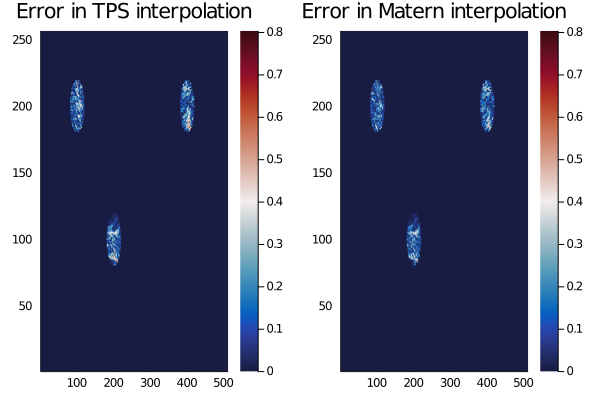

In [142]:
Error_TPS = abs.(mat - holeyimage_copy)
Error_Matern = abs.(mat - holeyimage_copy_m)
plot1 = heatmap(Error_TPS, c= :balance, title="Error in TPS interpolation");
plot2 = heatmap(Error_Matern, c= :balance, title="Error in Matern interpolation");
Plots.plot(plot1, plot2, layout = (1, 2), legend = false)

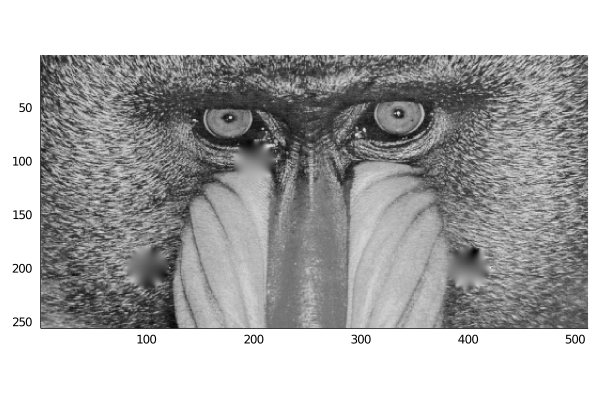

In [135]:
Plots.plot(Gray.(holeyimage_copy))

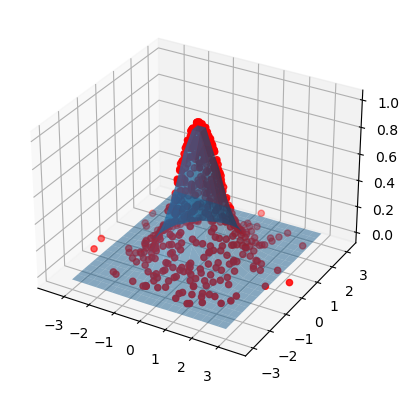

In [14]:
ENV["MPLBACKEND"]="tkagg" # if you need
using PyPlot
using LinearAlgebra

include("polyharmonic_splines.jl") 
# contain all code from https://github.com/lstagner/OrbitTomography.jl/blob/master/src/polyharmonic.jl
# and `interpolate()`definition from https://gist.github.com/lstagner/04a05b120e0be7de9915


x,y = randn(500),randn(500)
z = exp.(-(x.^2 .+ y.^2))
S2 = PolyharmonicSpline(2,[x y],z)

n=20
xgrid = ones(n)*range(-3,stop=3,length=n)'
ygrid = range(-3,stop=3,length=n)*ones(n)'

xx = reshape(xgrid,n*n)
yy = reshape(ygrid,n*n)

zz = interpolate(S2,xx,yy)
zgrid = reshape(zz,n,n);

plot_surface(xgrid,ygrid,zgrid,alpha=0.5)
scatter3D(x,y,z,color="r")
show()

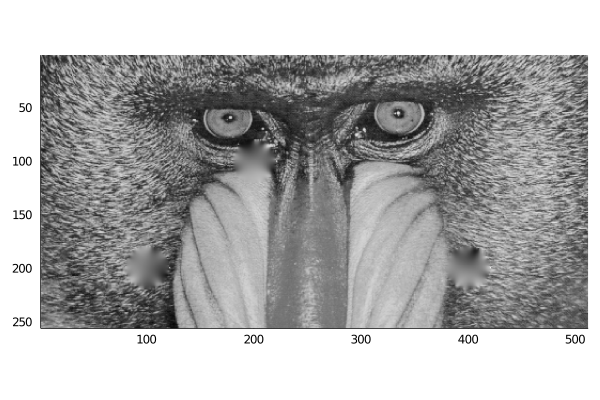

In [119]:
Plots.plot(Gray.(holeyimage_copy_m))

Take the laplacian matrix and plot it as a heatmap
Implement Dirichlet, Neumann, and Periodic BCs.

In [83]:
A2D = ∇²(10,10)

100×100 SparseMatrixCSC{Float64,Int64} with 460 stored entries:
  [1  ,   1]  =  4.0
  [2  ,   1]  =  -1.0
  [11 ,   1]  =  -1.0
  [1  ,   2]  =  -1.0
  [2  ,   2]  =  4.0
  [3  ,   2]  =  -1.0
  [12 ,   2]  =  -1.0
  [2  ,   3]  =  -1.0
  [3  ,   3]  =  4.0
  [4  ,   3]  =  -1.0
  [13 ,   3]  =  -1.0
  [3  ,   4]  =  -1.0
  ⋮
  [97 ,  97]  =  4.0
  [98 ,  97]  =  -1.0
  [88 ,  98]  =  -1.0
  [97 ,  98]  =  -1.0
  [98 ,  98]  =  4.0
  [99 ,  98]  =  -1.0
  [89 ,  99]  =  -1.0
  [98 ,  99]  =  -1.0
  [99 ,  99]  =  4.0
  [100,  99]  =  -1.0
  [90 , 100]  =  -1.0
  [99 , 100]  =  -1.0
  [100, 100]  =  4.0

In [89]:
A2D = Matrix(A2D);
A2D2 = A2D*A2D;

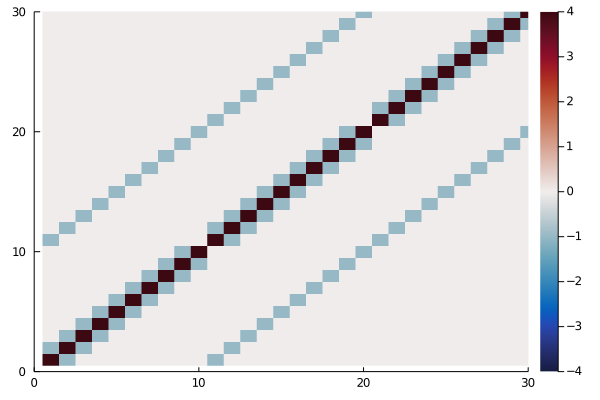

In [101]:
heatmap(A2D, c= :balance, clims=(-4, 4), xlim =[0,30], ylim =[0,30])

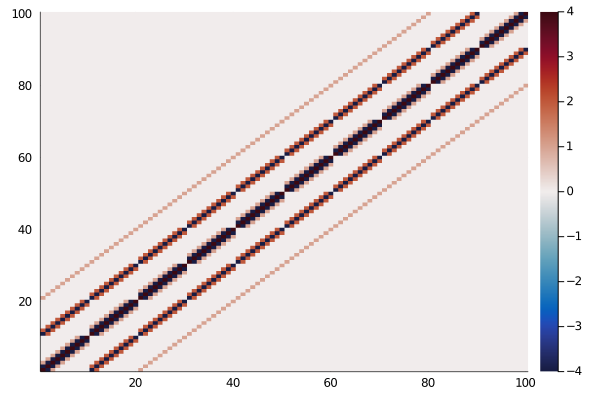

In [100]:
heatmap(A2D2, c= :balance, clims=(-4, 4))

In [102]:
include("../MaternKernelApproximation.jl")

Parallel_Matern3D_Grid

In [105]:
A3D = ∇²3d_Grid(4,4,4,1,1,1)

64×64 SparseMatrixCSC{Float64,Int64} with 352 stored entries:
  [1 ,  1]  =  3.0
  [2 ,  1]  =  -1.0
  [5 ,  1]  =  -1.0
  [17,  1]  =  -1.0
  [1 ,  2]  =  -1.0
  [2 ,  2]  =  4.0
  [3 ,  2]  =  -1.0
  [6 ,  2]  =  -1.0
  [18,  2]  =  -1.0
  [2 ,  3]  =  -1.0
  [3 ,  3]  =  4.0
  [4 ,  3]  =  -1.0
  ⋮
  [58, 62]  =  -1.0
  [61, 62]  =  -1.0
  [62, 62]  =  4.0
  [63, 62]  =  -1.0
  [47, 63]  =  -1.0
  [59, 63]  =  -1.0
  [62, 63]  =  -1.0
  [63, 63]  =  4.0
  [64, 63]  =  -1.0
  [48, 64]  =  -1.0
  [60, 64]  =  -1.0
  [63, 64]  =  -1.0
  [64, 64]  =  3.0

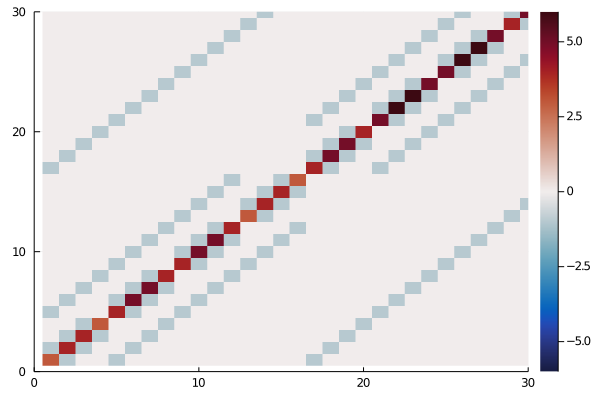

In [107]:
heatmap(Matrix(A3D), c= :balance, clims=(-6, 6), xlim =[0,30], ylim =[0,30])

In [109]:
A3D2 = A3D*A3D

64×64 SparseMatrixCSC{Float64,Int64} with 976 stored entries:
  [1 ,  1]  =  12.0
  [2 ,  1]  =  -7.0
  [3 ,  1]  =  1.0
  [5 ,  1]  =  -7.0
  [6 ,  1]  =  2.0
  [9 ,  1]  =  1.0
  [17,  1]  =  -7.0
  [18,  1]  =  2.0
  [21,  1]  =  2.0
  [33,  1]  =  1.0
  [1 ,  2]  =  -7.0
  [2 ,  2]  =  20.0
  ⋮
  [62, 63]  =  -8.0
  [63, 63]  =  20.0
  [64, 63]  =  -7.0
  [32, 64]  =  1.0
  [44, 64]  =  2.0
  [47, 64]  =  2.0
  [48, 64]  =  -7.0
  [56, 64]  =  1.0
  [59, 64]  =  2.0
  [60, 64]  =  -7.0
  [62, 64]  =  1.0
  [63, 64]  =  -7.0
  [64, 64]  =  12.0

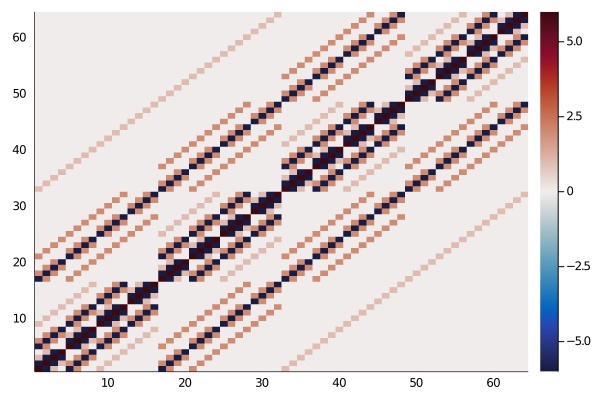

In [112]:
heatmap(Matrix(A3D2), c= :balance, clims=(-6, 6))#, xlim =[0,16], ylim =[0,16])